# EasyFlux-DL Footprint Recalculation

Recalculate FETCH values (FETCH_MAX, FETCH_90, FETCH_55, FETCH_40) from eddy-covariance
station data using updated site parameters. This notebook implements both footprint models
from the Campbell Scientific EasyFlux-DL program:

- **Kljun et al. (2004)** — used when −200 ≤ z/L ≤ 1, u* ≥ 0.2 m/s, and z ≥ 1 m
- **Kormann & Meixner (2001)** — used for all other conditions

The Python functions in `easyflux_footprint.py` are a faithful line-by-line translation
of the CRBASIC subroutines, including the same numerical integration approach (trapezoidal
rule for high-resolution segments, Boole's rule for coarser segments).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../src/")
import micromet
from micromet import easyflux_footprint

## 1. Site Configuration

**Edit the parameters below** to match your site. These are the values you want to
update for recalculation:

| Parameter | Description |
|-----------|-------------|
| `z` | Aerodynamic measurement height above zero-plane displacement [m] |
| `z0` | Roughness length [m]. Set to 0 for automatic estimation (EasyFlux-DL default). |
| `sonic_azimuth` | Compass bearing of the CSAT3 positive-x axis [degrees] |
| `dist_intrst` | Upwind distance of interest [m] per wind direction sector |

The wind direction sectors follow the EasyFlux-DL convention based on WD_SONIC
(wind direction in the CSAT coordinate system, not compass direction):
- `60_300`: WD_SONIC ≤ 60° or WD_SONIC ≥ 300°
- `60_170`: 60° < WD_SONIC ≤ 170°
- `170_190`: 170° < WD_SONIC < 190°
- `190_300`: 190° ≤ WD_SONIC < 300°


In [2]:
# ============================================================
# >>>  EDIT THESE PARAMETERS FOR YOUR SITE  <<<
# ============================================================

cfg = easyflux_footprint.SiteConfig(
    z=1.64,              # measurement height [m] — UPDATE THIS
    z0=0.01,             # roughness length [m]   — UPDATE THIS
    sonic_azimuth=0.0,   # CSAT3 azimuth [degrees] — UPDATE THIS
    dist_intrst={        # upwind distance of interest per sector [m]
        '60_300':  500.0,   # — UPDATE THESE
        '60_170':  500.0,
        '170_190': 500.0,
        '190_300': 500.0,
    },
    n_int=100,           # integration intervals (default 100, matching EasyFlux-DL)
)

# To use the same distance for all sectors, uncomment:
# cfg.set_uniform_dist(500.0)

print(f"Site config: z={cfg.z} m, z0={cfg.z0} m, azimuth={cfg.sonic_azimuth}°")
print(f"Upwind distances: {cfg.dist_intrst}")


Site config: z=1.64 m, z0=0.01 m, azimuth=0.0°
Upwind distances: {'60_300': 500.0, '60_170': 500.0, '170_190': 500.0, '190_300': 500.0}


## 2. Load Data

Load the EasyFlux-DL output file. The code expects the AmeriFlux-style column naming
convention (e.g., `USTAR_1_1_1`, `ZL_1_1_1`). If your columns differ, update the
`col_map` dictionary.


In [7]:
# Load data
DATA_PATH = 'data_sample.csv'  # ← UPDATE path to your data file

df = pd.read_csv(DATA_PATH, index_col=0)
df = df.replace(-9999.0, np.nan)
df['DATETIME_END'] = pd.to_datetime(df['DATETIME_END'])

# Column mapping — update if your column names differ
col_map = {
    'ustar':     'USTAR_1_1_1',
    'w_sigma':   'W_SIGMA_1_1_1',
    'zl':        'ZL_1_1_1',
    'mo_length': 'MO_LENGTH_1_1_1',
    'ws_rslt':   'WS_1_1_1',
    'wd':        'WD_1_1_1',
}

# Quick overview
valid_mask = df['FETCH_MAX'].notna()
print(f"Total records: {len(df)}")
print(f"Records with valid original FETCH: {valid_mask.sum()}")
print(f"Date range: {df['DATETIME_END'].min()} to {df['DATETIME_END'].max()}")


Total records: 1000
Records with valid original FETCH: 90
Date range: 2024-06-05 12:30:00 to 2024-06-26 08:00:00


## 3. Recalculate FETCH Values

This applies both footprint models row-by-row using your updated site configuration.
New columns are appended: `FETCH_MAX_new`, `FETCH_90_new`, `FETCH_55_new`,
`FETCH_40_new`, `FP_DIST_INTRST_new`, `FP_EQUATION_new`.


In [8]:
# Recalculate footprints with new parameters
df_out = easyflux_footprint.recalculate_fetch(df, cfg, col_map=col_map)

# Summary of which model was used
eq_counts = df_out.loc[df_out['FETCH_MAX_new'].notna(), 'FP_EQUATION_new'].value_counts()
print("Footprint model usage:")
print(eq_counts)
print()

# Preview results
cols_preview = ['DATETIME_END', 'FETCH_MAX', 'FETCH_MAX_new', 'FETCH_90', 'FETCH_90_new',
                'FETCH_55_new', 'FETCH_40_new', 'FP_EQUATION_new']
print(df_out.loc[df_out['FETCH_MAX_new'].notna(), cols_preview].head(15).to_string(index=False))


Footprint model usage:
FP_EQUATION_new
KormannMeixner    58
Kljun et al       32
Name: count, dtype: int64

       DATETIME_END  FETCH_MAX  FETCH_MAX_new   FETCH_90  FETCH_90_new  FETCH_55_new  FETCH_40_new FP_EQUATION_new
2024-06-05 15:30:00  18.927840      21.154423 755.052200    850.223276     96.962755     58.202483  KormannMeixner
2024-06-05 16:00:00  28.544620      37.276213  80.453620    104.935381     53.377396     40.363207     Kljun et al
2024-06-05 16:30:00  23.522360      30.717676  67.053240     87.400734     44.141848     33.363676     Kljun et al
2024-06-05 17:00:00  27.700920      36.174427  78.555550    102.436139     51.908331     39.241348     Kljun et al
2024-06-05 17:30:00  23.170490      30.258173  66.092020     86.143765     43.489353     32.869719     Kljun et al
2024-06-05 18:00:00  23.462850      30.639969  66.994920     87.319042     44.055084     33.295606     Kljun et al
2024-06-05 18:30:00  21.873770      28.564803  62.420320     81.348336     41.055331   

## 4. Compare Original vs. Recalculated

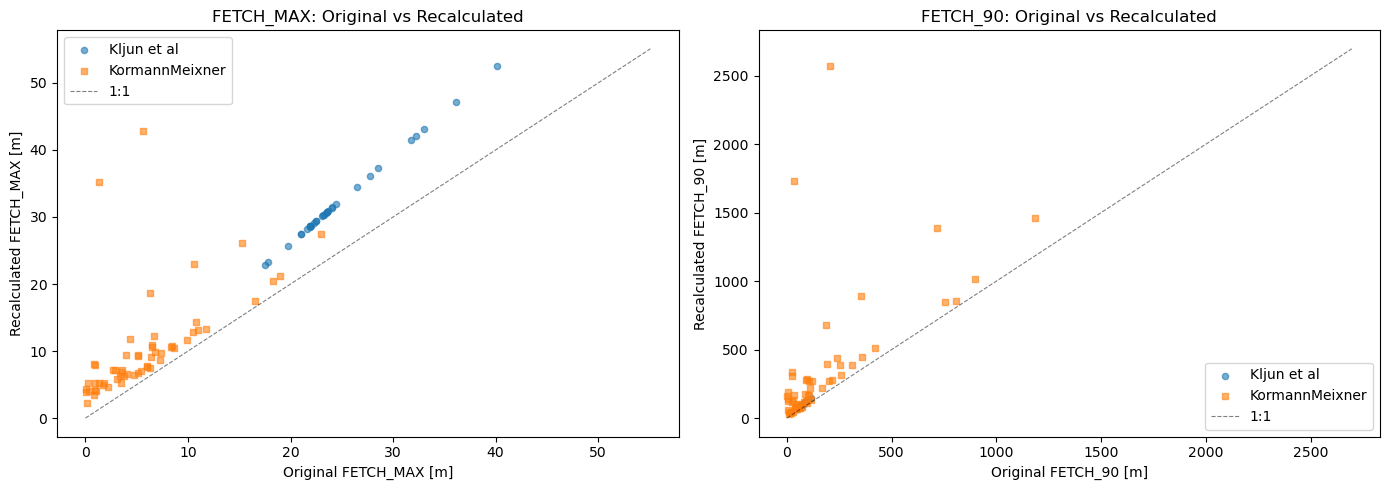

In [9]:
# Filter to rows with both original and new valid FETCH
comp = df_out[(df_out['FETCH_MAX'].notna()) & (df_out['FETCH_MAX_new'].notna())].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# FETCH_MAX comparison
ax = axes[0]
for eq, marker, color in [('Kljun et al', 'o', 'tab:blue'), ('KormannMeixner', 's', 'tab:orange')]:
    mask = comp['FP_EQUATION_new'] == eq
    ax.scatter(comp.loc[mask, 'FETCH_MAX'], comp.loc[mask, 'FETCH_MAX_new'],
               alpha=0.6, s=20, marker=marker, color=color, label=eq)
lim = max(comp['FETCH_MAX'].max(), comp['FETCH_MAX_new'].max()) * 1.05
ax.plot([0, lim], [0, lim], 'k--', lw=0.8, alpha=0.5, label='1:1')
ax.set_xlabel('Original FETCH_MAX [m]')
ax.set_ylabel('Recalculated FETCH_MAX [m]')
ax.set_title('FETCH_MAX: Original vs Recalculated')
ax.legend()

# FETCH_90 comparison
ax = axes[1]
for eq, marker, color in [('Kljun et al', 'o', 'tab:blue'), ('KormannMeixner', 's', 'tab:orange')]:
    mask = comp['FP_EQUATION_new'] == eq
    ax.scatter(comp.loc[mask, 'FETCH_90'], comp.loc[mask, 'FETCH_90_new'],
               alpha=0.6, s=20, marker=marker, color=color, label=eq)
lim = max(comp['FETCH_90'].max(), comp['FETCH_90_new'].max()) * 1.05
ax.plot([0, lim], [0, lim], 'k--', lw=0.8, alpha=0.5, label='1:1')
ax.set_xlabel('Original FETCH_90 [m]')
ax.set_ylabel('Recalculated FETCH_90 [m]')
ax.set_title('FETCH_90: Original vs Recalculated')
ax.legend()

plt.tight_layout()
plt.show()


## 5. Time Series Comparison

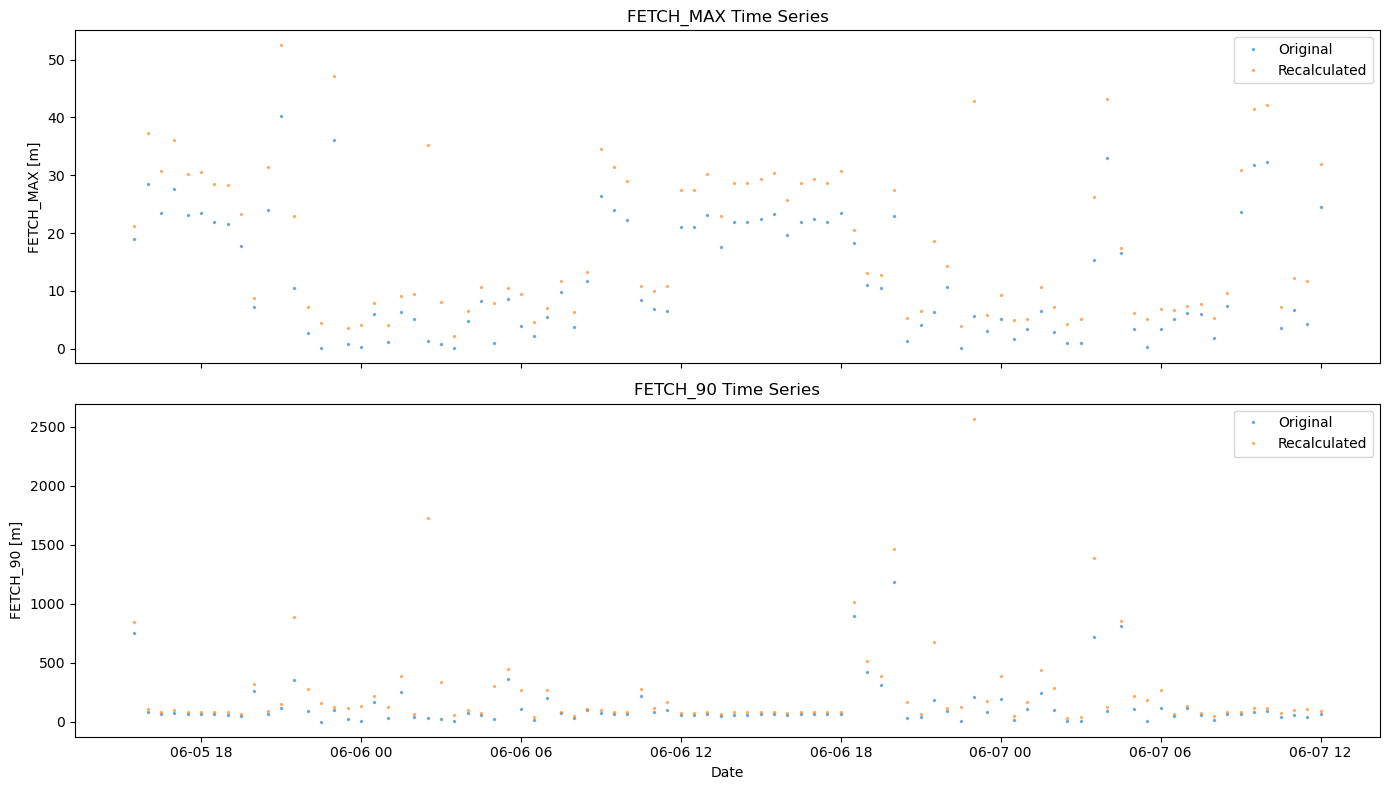

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

valid = df_out[df_out['FETCH_MAX_new'].notna()]

ax = axes[0]
ax.plot(valid['DATETIME_END'], valid['FETCH_MAX'], '.', ms=3, alpha=0.5, label='Original')
ax.plot(valid['DATETIME_END'], valid['FETCH_MAX_new'], '.', ms=3, alpha=0.5, label='Recalculated')
ax.set_ylabel('FETCH_MAX [m]')
ax.set_title('FETCH_MAX Time Series')
ax.legend()

ax = axes[1]
ax.plot(valid['DATETIME_END'], valid['FETCH_90'], '.', ms=3, alpha=0.5, label='Original')
ax.plot(valid['DATETIME_END'], valid['FETCH_90_new'], '.', ms=3, alpha=0.5, label='Recalculated')
ax.set_ylabel('FETCH_90 [m]')
ax.set_xlabel('Date')
ax.set_title('FETCH_90 Time Series')
ax.legend()

plt.tight_layout()
plt.show()


## 6. Single-Period Calculation

You can also calculate footprint characteristics for individual periods directly:


In [12]:
# Example: calculate for a single period
result = easyflux_footprint.calc_footprint(
    ustar=0.31,       # friction velocity [m/s]
    w_sigma=0.28,      # σ_w [m/s]
    zl=0.024,          # z/L stability
    mo_length=69.6,    # Monin-Obukhov length [m]
    ws_rslt=2.34,      # resultant wind speed [m/s]
    wd_compass=231.0,  # compass wind direction [degrees]
    cfg=cfg,
)

print(f"Model used:      {result.fp_equation}")
print(f"FETCH_MAX:       {result.fetch_max:.1f} m")
print(f"FETCH_90:        {result.fetch_90:.1f} m")
print(f"FETCH_55:        {result.fetch_55:.1f} m")
print(f"FETCH_40:        {result.fetch_40:.1f} m")
print(f"FP at dist_intrst: {result.fp_dist_intrst:.1f}%")


Model used:      Kljun et al
FETCH_MAX:       37.0 m
FETCH_90:        104.2 m
FETCH_55:        53.0 m
FETCH_40:        40.1 m
FP at dist_intrst: 99.0%


## 7. Export Results

In [ ]:
# Export to CSV
output_cols = ['DATETIME_END', 'WD_1_1_1', 'WS_1_1_1', 'USTAR_1_1_1', 'ZL_1_1_1',
               'MO_LENGTH_1_1_1', 'W_SIGMA_1_1_1',
               'FETCH_MAX', 'FETCH_MAX_new', 'FETCH_90', 'FETCH_90_new',
               'FETCH_55_new', 'FETCH_40_new', 'FP_DIST_INTRST_new', 'FP_EQUATION_new']

df_out[output_cols].to_csv('fetch_recalculated.csv', index=False)
print("Saved to fetch_recalculated.csv")


## Appendix: Model Selection Logic

The footprint model selection follows the EasyFlux-DL convention:

```
if  z/L ≥ −200  AND  z/L ≤ 1  AND  u* ≥ 0.2 m/s  AND  z ≥ 1 m:
    → Kljun et al. (2004)
else:
    → Kormann & Meixner (2001)
```

The **roughness length** (`z0`) is optionally auto-updated under near-neutral conditions
(|z/L| < 0.02, WS > 3 m/s, TAU_QC ≤ 6) via `z0 = z × exp(−κ × WS / u*)`. This
auto-update is **not** applied in the current recalculation since you're providing a
fixed `z0`. If you need dynamic z0, you can extend the code by filtering for those
conditions in your DataFrame and updating `cfg.z0` per-row.

### References

- Kljun, N., Calanca, P., Rotach, M.W. & Schmid, H.P. (2004). A simple parameterisation
  for flux footprint predictions. *Boundary-Layer Meteorol.*, 112, 503–523.
- Kormann, R. & Meixner, F.X. (2001). An analytical footprint model for non-neutral
  stratification. *Boundary-Layer Meteorol.*, 99, 207–224.
- Nemes, G. (2007). New asymptotic expansion for the Gamma function.
  *Archiv der Mathematik*, 89, 95–107.
